# Setup

In [1]:
%matplotlib widget
%autoreload 2
%load_ext autoreload

import sys, os, pickle, pdb, shutil, re, math, glob
from copy import deepcopy, copy
from pathlib import Path
from pprint import pprint
from typing import Union, Callable
from dataclasses import dataclass

import psutil
from tqdm.notebook import tqdm
import pandas as pd, numpy as np, torch, matplotlib.pyplot as plt

import torchvision.transforms as T
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from ipywidgets import interact
import skimage.io
import SimpleITK as sitk


from whack.penalty_functions import mse_penalty, exact_penalty, super_exact_penalty
from whack.penalties import LIME_penalty, SHAP_penalty, LIME_focus

# import the shap module
paths = [Path("").parent.absolute() / "shap", Path("").parent.absolute() / "shap_original"]
for path in paths:
    if str(path) not in sys.path:
        sys.path.insert(0, str(path))
import shap, shap_original

# set the global dtype and device to work with
DTYPE, DEVICE = torch.float32, torch.device("cuda")
TOPTS = dict(dtype=DTYPE, device=DEVICE)  # tensor options
plt.rcParams["figure.dpi"] = 200

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
image_root = Path("/media/rdyro/Storage/datasets/LUNA16").absolute() / "mhd"
image_fnames = glob.glob(str(image_root / "*.mhd"))

text_root = Path("").absolute() / "data" / "lung"
annotations_df = pd.read_csv(text_root / "annotations.csv")
candidates_df = pd.read_csv(text_root / "candidates_V2.csv")
data_df = candidates_df

all_samples = np.unique(data_df["seriesuid"])

fname = Path("").absolute() / "data" / "candidates_dict.bin"
if fname.exists():
    cand_map = torch.load(fname)
else:
    cand_map = dict()
    for (i, row) in candidates_df.iterrows():
        name = row["seriesuid"]
        cand_map.setdefault(name, [])
        x, y, z, c = row["coordX"], row["coordY"], row["coordZ"], row["class"]
        cand_map[name].append([x, y, z, c])
    for k in cand_map.keys():
        cand_map[k] = np.array(cand_map[k])
    torch.save(cand_map, fname)

In [3]:
def xyz2pixels(image: sitk.SimpleITK.Image, x, y, z):
    return image.TransformPhysicalPointToIndex((x, y, z))
    # return tuple((np.array([x, y, z]) - np.array(image.GetOrigin())) / np.array(image.GetSpacing()))


def pixels2xyz(image, px, py, pz):
    return image.TransformIndexToPhysicalPoint((px, py, pz))
    # return tuple(np.array([px, py, pz]) * np.array(image.GetSpacing()) + np.array(image.GetOrigin()))


def get_class(name, x, y, z):
    d = np.linalg.norm(cand_map[name][:, :3] - np.array([x, y, z]), axis=-1)
    idx = np.argmin(d)
    assert d[idx] <= 2
    return cand_map[name][idx, -1]


def crop_positive(name, size=30):
    img_path = image_root / (name + ".mhd")
    reader = sitk.ImageFileReader()
    reader.SetImageIO("MetaImageIO")
    reader.SetFileName(str(img_path))
    image = reader.Execute()
    img = sitk.GetArrayFromImage(image)
    # img = img.transpose((1, 2, 0))
    img = img.transpose((2, 1, 0))
    all_cands = annotations_df[["coordX", "coordY", "coordZ", "diameter_mm"]][annotations_df["seriesuid"] == name]
    all_cands = np.array(all_cands.loc[all_cands.index])
    crops = []
    if len(all_cands) == 0:
        return crops
    for (x, y, z, diam) in all_cands:
        try:
            c = get_class(name, x, y, z)
            assert c == 1.0
        except AssertionError:
            continue
        try:
            px, py, pz = map(round, xyz2pixels(image, x, y, z))
            assert px >= 0 and px < img.shape[0], f"px = {px}, {img.shape}"
            assert py >= 0 and py < img.shape[1], f"py = {py}, {img.shape}"
            assert pz >= 0 and pz < img.shape[2], f"pz = {pz}, {img.shape}"

            xl, xu = max(px - size, 0), min(px + size, img.shape[0])
            yl, yu = max(py - size, 0), min(py + size, img.shape[1])
            zl, zu = max(pz - size, 0), min(pz + size, img.shape[2])
            assert xu - xl == 2 * size and yu - yl == 2 * size and zu - zl == 2 * size
            crop = np.copy(img[xl:xu, yl:yu, zl:zu])
            crops.append(crop)
        except AssertionError:
            continue
    return crops


def crop_negative(name, size=30):
    img_path = image_root / (name + ".mhd")
    reader = sitk.ImageFileReader()
    reader.SetImageIO("MetaImageIO")
    reader.SetFileName(str(img_path))
    image = reader.Execute()
    img = sitk.GetArrayFromImage(image)
    # img = img.transpose((1, 2, 0))
    img = img.transpose((2, 1, 0))
    all_cands = candidates_df[["coordX", "coordY", "coordZ", "class"]][candidates_df["seriesuid"] == name]
    all_cands = np.array(all_cands.loc[all_cands.index])
    crops = []
    if len(all_cands) == 0:
        return crops
    for (x, y, z, c) in all_cands:
        try:
            px, py, pz = map(round, xyz2pixels(image, x, y, z))
            assert px >= 0 and px < img.shape[0], f"px = {px}, {img.shape}"
            assert py >= 0 and py < img.shape[1], f"py = {py}, {img.shape}"
            assert pz >= 0 and pz < img.shape[2], f"pz = {pz}, {img.shape}"

            xl, xu = max(px - size, 0), min(px + size, img.shape[0])
            yl, yu = max(py - size, 0), min(py + size, img.shape[1])
            zl, zu = max(pz - size, 0), min(pz + size, img.shape[2])
            assert xu - xl == 2 * size and yu - yl == 2 * size and zu - zl == 2 * size
            crop = np.copy(img[xl:xu, yl:yu, zl:zu])
            crops.append(crop)
            if len(crops) > 3:
                return crops
        except AssertionError:
            continue
    return crops


########################################################################################################################

sample_nb, size = int(1e3), 30


class CropDataset(torch.utils.data.Dataset):
    def __init__(self, fn):
        self.fn = fn

    def __getitem__(self, idx):
        print(idx, end=" ")
        crops = self.fn(all_samples[idx], size=30)
        return crops

    def __len__(self):
        return len(all_samples)


def collate_fn(xs):
    return sum(xs, [])

In [4]:
PosDataLoader = DataLoader(CropDataset(crop_positive), num_workers=8, collate_fn=collate_fn, batch_size=8)
NegDataLoader = DataLoader(CropDataset(crop_negative), num_workers=8, collate_fn=collate_fn, batch_size=8)

# fname = Path("").absolute() / "data" / "positive_crops.bin"
fname = Path("~/").expanduser().absolute() / "datasets" / "positive_crops.bin"
if fname.exists():
    all_pos = torch.load(fname)
else:
    all_pos = sum([crops for crops in PosDataLoader], [])
    all_pos = np.stack(all_pos)
    amax, amin = np.max(all_pos, (1, 2, 3))[..., None, None, None], np.min(all_pos, (1, 2, 3))[..., None, None, None]
    all_pos = (all_pos - amin) / (amax - amin)
    torch.save(all_pos.astype(np.float32), fname)

# fname = Path("").absolute() / "data" / "negative_crops.bin"
fname = Path("~/").expanduser().absolute() / "datasets" / "negative_crops.bin"
if fname.exists():
    all_neg = torch.load(fname)
else:
    all_neg = sum([crops for crops in NegDataLoader], [])[: len(all_pos)]
    all_neg = np.stack(all_neg)
    amax, amin = np.max(all_neg, (1, 2, 3))[..., None, None, None], np.min(all_neg, (1, 2, 3))[..., None, None, None]
    all_neg = (all_neg - amin) / (amax - amin)
    torch.save(all_neg.astype(np.float32), fname)

### visualize positive and negative examples

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
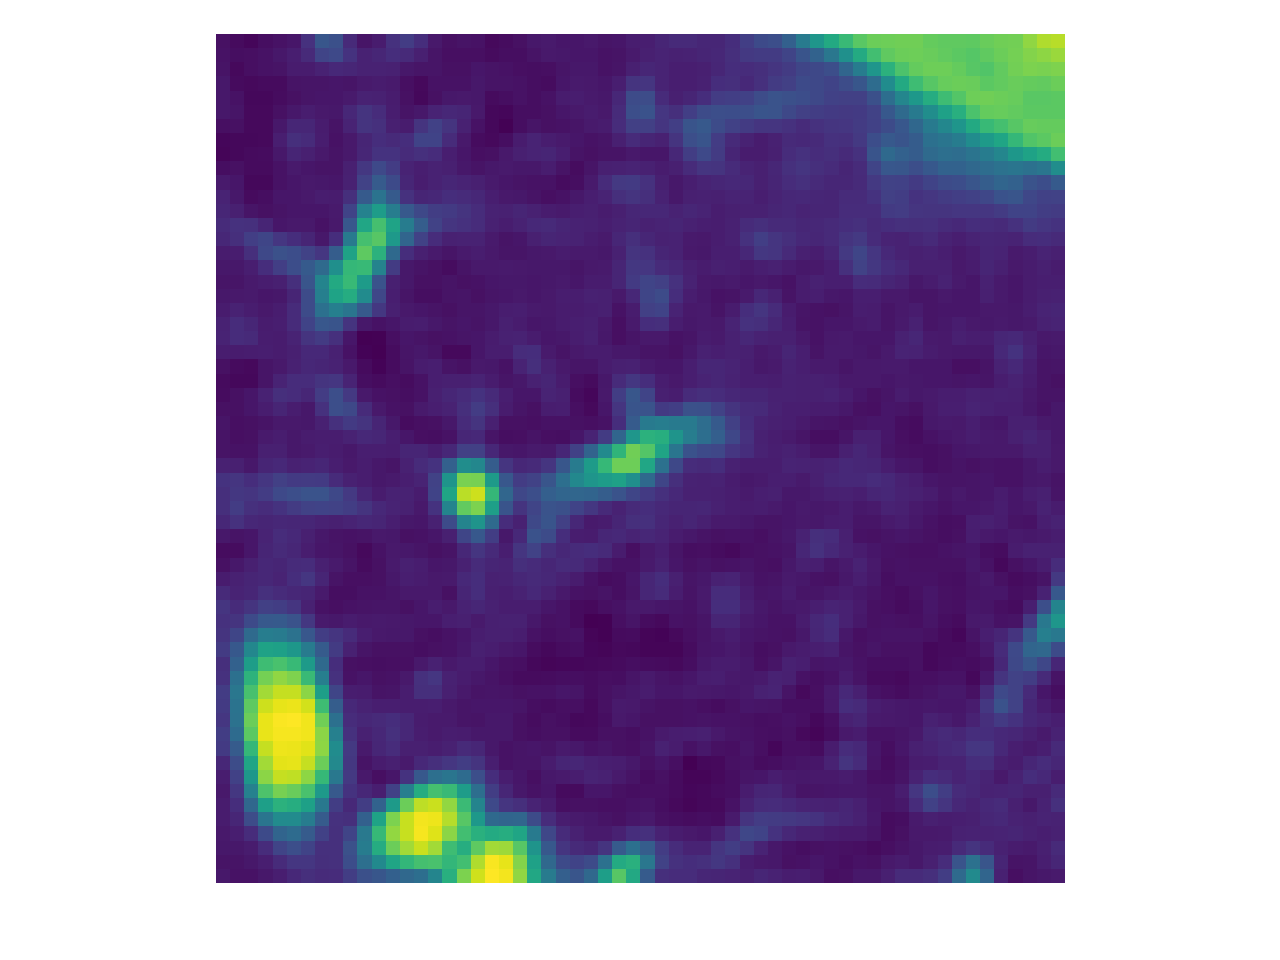

In [5]:
for i in range(3):
    plt.figure(4534543)
    plt.clf()
    r = np.random.randint(0, min(len(all_neg), len(all_pos)))
    plt.imshow(all_pos[r][:, :, all_pos[r].shape[2] // 2])
    # plt.imshow(all_neg[r][:, :, all_neg[r].shape[2] // 2])
    plt.tight_layout()
    plt.axis("off")
    plt.savefig(Path("") / "figures" / f"positive_crop_{i}.png", bbox_inches="tight")
    # plt.show()

for i in range(3):
    plt.figure(4534543)
    plt.clf()
    r = np.random.randint(0, min(len(all_neg), len(all_pos)))
    # plt.imshow(all_pos[r][:, :, all_pos[r].shape[2] // 2])
    plt.imshow(all_neg[r][:, :, all_neg[r].shape[2] // 2])
    plt.tight_layout()
    plt.axis("off")
    plt.savefig(Path("") / "figures" / f"negative_crop_{i}.png", bbox_inches="tight")

plt.show()

In [6]:
all_crops = np.concatenate([all_pos, all_neg])
labels = np.concatenate([np.ones(all_pos.shape[0], dtype=np.int32), np.zeros(all_neg.shape[0], dtype=np.int32)], 0)
mask = np.all(np.logical_not(np.isnan(all_crops)), (-1, -2, -3))
all_crops, labels = all_crops[mask, ...], labels[mask, ...]
STD = torch.std(torch.as_tensor(all_crops, dtype=DTYPE, device=DEVICE), 0)


class CroppedDataset(torch.utils.data.Dataset):
    def __init__(self, *args, **kw):
        super().__init__(*args, **kw)

    def __getitem__(self, idx):
        img_3d = torch.as_tensor(all_crops[idx], dtype=torch.float32)  # [None, ...]
        return (img_3d, labels[idx])

    def __len__(self):
        return len(labels)


def collate_fn(xs):
    return torch.utils.data.default_collate([x for x in xs if not torch.any(torch.isnan(x[0]))])


train_samples = round(0.8 * len(labels))
test_samples = len(labels) - train_samples
dataset = CroppedDataset()
train_set, test_set = torch.utils.data.random_split(dataset, [train_samples, test_samples])
train_loader = torch.utils.data.DataLoader(
    train_set, num_workers=0, batch_size=128, shuffle=True, collate_fn=collate_fn
)
test_loader = torch.utils.data.DataLoader(test_set, num_workers=0, batch_size=128, shuffle=True, collate_fn=collate_fn)

In [7]:
size = 60
X_idx = torch.arange(size)[:, None, None].repeat((1, size, size))
Y_idx = torch.arange(size)[None, :, None].repeat((size, 1, size))
Z_idx = torch.arange(size)[None, None, :].repeat((size, size, 1))
MASK = torch.sqrt((X_idx - size // 2) ** 2 + (Y_idx - size // 2) ** 2 + (Z_idx - size // 2) ** 2) <= 10


@interact(i=(0, size - 1))
def plot(i=0):
    plt.figure(54323423)
    plt.clf()
    plt.imshow(MASK[:, :, i])
    plt.colorbar()
    plt.show()

interactive(children=(IntSlider(value=0, description='i', max=59), Output()), _dom_classes=('widget-interact',…

In [8]:
def generate_model(config):
    activation = torch.nn.Softplus(1e1)
    model = (
        torch.nn.Sequential(
            torch.nn.Conv2d(60, 32, 7, 2),
            copy(activation),
            torch.nn.Conv2d(32, 32, 5, 2),
            copy(activation),
            torch.nn.Conv2d(32, 32, 3, 1),
            copy(activation),
            torch.nn.Conv2d(32, 8, 3, 1),
            copy(activation),
            torch.nn.Flatten(),
            torch.nn.Linear(512, 1),
            torch.nn.Sigmoid(),
        )
        .to(DTYPE)
        .to(DEVICE)
    )
    loss_obj = torch.nn.BCELoss()

    def loss_fn(Yp, Y, **kw):
        kw = dict(config, **kw)
        loss = loss_obj(Yp, Y)
        loss = loss + sum(config["lam"] * torch.sum(param**2) / 2 for param in model.parameters())
        return loss

    def cstr_fn(**kw):
        kw = dict(config, **kw)
        penalty_fn = lambda x: exact_penalty(x, kw.get("gam", None))
        #penalty_fn = lambda x: mse_penalty(x, kw.get("gam", None))

        if kw.get("method", "").lower() == "lime":
            loss_penalty = LIME_focus(
                MASK,
                model,
                train_loader.dataset,
                STD,
                penalty_fn=penalty_fn,
                test_samples=kw["test_samples"],
                bg_samples=kw["bg_samples"],
                sample_std=kw["sample_std"],
            )
        elif kw.get("method", "").lower() == "shap":
            loss_penalty = SHAP_focus(
                MASK,
                model,
                train_loader.dataset,
                penalty_fn=penalty_fn,
                test_samples=kw["test_samples"],
                bg_samples=kw["bg_samples"],
            )
        else:
            loss_penalty = (0, (None for _ in model.parameters()))
        return loss_penalty

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=60, gamma=0.3)
    return model, loss_fn, cstr_fn, optimizer, scheduler


def accuracy(model, loader):
    correct = 0
    with torch.no_grad():
        for X, Y in loader:
            X, Y = X.to(DTYPE).to(DEVICE), Y.to(DEVICE)
            Yp = model(X)
            correct += torch.sum((Yp > 0.5).reshape(Y.shape) == Y).detach()
    return correct / len(loader.dataset)

# LIME Experiments

In [9]:
def main(config):
    model, loss_fn, cstr_fn, optimizer, scheduler = generate_model(config)
    if config.get("method", "") == "":
        optimizer.param_groups[0]["lr"] = 1e-3
    shutil.rmtree(Path("") / "runs")
    writer = SummaryWriter()
    rng = tqdm(range(int(150)))
    step = -1
    hist = dict()
    for epoch in rng:
        for (i, (X, Y)) in enumerate(train_loader):
            step += 1
            X, Y = X.to(DTYPE).to(DEVICE, non_blocking=True), Y.to(DTYPE).to(
                DEVICE, non_blocking=True
            )  # sample a batch
            optimizer.zero_grad()  # zero gradients
            cstr_val = 0
            if epoch > 10:
                cstr_val, grads = cstr_fn()
                for (grad, param) in zip(grads, model.parameters()):
                    if grad is not None:
                        param.grad = grad
            Yp = model(X).reshape(Y.shape)
            loss = loss_fn(Yp, Y)
            loss.backward()

            optimizer.step()
            writer.add_scalar("loss/train", float(loss), step)
            writer.add_scalar("step_size", float(optimizer.param_groups[0]["lr"]), step)
            writer.add_scalar("penalty_metric", float(cstr_val), step)

            hist.setdefault("loss_train", []).append(float(loss))
            hist.setdefault("penalty_metric", []).append(float(cstr_val))
            writer.flush()
        scheduler.step()
        train_acc, test_acc = accuracy(model, train_loader), accuracy(model, test_loader)
        rng.set_description(f"Accuracy = (test = {1e2 * test_acc:.3f}%, train = {1e2 * train_acc:.3f}%)")
        writer.add_scalar("Accuracy/test", test_acc, step)
        writer.add_scalar("Accuracy/train", train_acc, step)
        hist.setdefault("acc_test", []).append(float(test_acc))
        hist.setdefault("acc_train", []).append(float(train_acc))
    fname = Path("~/datasets").expanduser().absolute() / f"model_snap_{np.random.randint(0, int(1e9)):d}.bin"
    torch.save((config, hist, model), fname)


# config = dict(test_samples=int(1e0), bg_samples=int(1e2), method="SHAP", lam=1e-3, gam=1e0)
config = dict(method="", lam=1e-3)
main(config)
config = dict(test_samples=int(32), bg_samples=int(16), sample_std=1e-2, method="LIME", lam=1e-3, gam=1e2)
main(config)


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

--------------------------------------------------------------------------------

# Figures generations

In [13]:
paths = glob.glob(str(Path("~").expanduser() / "datasets" / "model_snap_*.bin"))
acc_df = pd.DataFrame(
    {
        "Name": [],
        "Train Accuracy": [],
        "Test Accuracy": [],
        "Penalty Value": [],
    }
)

gam, sample_std, bg_samples, test_samples = None, None, None, None

for path in paths:
    (config, hist, model) = torch.load(path)
    gam = gam if "gam" not in config else config["gam"]
    sample_std = sample_std if "sample_std" not in config else config["sample_std"]
    bg_samples = bg_samples if "bg_samples" not in config else config["bg_samples"]
    test_samples = test_samples if "test_samples" not in config else config["test_samples"]

for path in paths:
    (config, hist, model) = torch.load(path)
    penalty_vals = []
    for i in tqdm(range(20)):
        penalty_val, _ = LIME_focus(
            MASK,
            model,
            train_loader.dataset,
            STD,
            penalty_fn=lambda x: exact_penalty(x, gam),
            test_samples=test_samples,
            bg_samples=bg_samples,
            sample_std=sample_std,
        )
        penalty_vals.append(float(penalty_val))

    penalty_val = np.mean(penalty_vals)
    acc_df.loc[len(acc_df)] = [
        "LIME Penalized" if config.get("method") == "LIME" else "Baseline",
        float(hist["acc_train"][-1]),
        float(hist["acc_test"][-1]),
        float(penalty_val),
    ]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [14]:
acc_df

,Name,Train Accuracy,Test Accuracy,Penalty Value
0,Baseline,0.997503,0.7975,0.442316
1,LIME Penalized,0.788390,0.7225,0.346396


In [27]:
print(torch.sum(1 * torch.logical_not(MASK)))
print(torch.sum(1 * MASK))
print(sum(param.numel() for param in model.parameters()))
print(list(model.parameters())[0].shape)

tensor(211831)
tensor(4169)
131817
torch.Size([32, 60, 7, 7])


In [19]:
print(acc_df.to_latex(index=False))

\begin{tabular}{lrrr}
\toprule
          Name &  Train Accuracy &  Test Accuracy &  Penalty Value \\
\midrule
      Baseline &        0.997503 &         0.7975 &       0.442316 \\
LIME Penalized &        0.788390 &         0.7225 &       0.346396 \\
\bottomrule
\end{tabular}



In [24]:
print(np.sum(np.all(np.logical_not(np.isnan(all_pos)), (-1, -2, -3))))
print(np.sum(np.all(np.logical_not(np.isnan(all_neg)), (-1, -2, -3))))

986
1016
